# Insight into the training/validation data

This notebook (as much of the data splitting code) is based on David's notebook, with some reworks to much of the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
import time
import datetime
import csv
import pandas
import copy
import pickle
import math

from IPython.display import display, HTML

from sklearn.externals import joblib
from sklearn.pipeline import make_pipeline, make_union
import sklearn.linear_model
import sklearn.dummy
import sklearn.metrics
import sklearn.ensemble
import sklearn.calibration
import sklearn.preprocessing
import sklearn.model_selection

%matplotlib inline

import seaborn as sns
def setSnsStyle(style):
    sns.set(style=style, font_scale=1.5)
    font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 30}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['xtick.labelsize'] = 16 
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['axes.titlesize'] = 16
    matplotlib.rcParams['axes.labelsize'] = 16
    
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'retina'

setSnsStyle("ticks")

In [2]:
import exifread
import struct
import binascii

import os
import sys
base_path = os.path.abspath(os.pardir)
sys.path.append(base_path)

from data_utils import data_reader

---
## Check the format of the EXIF MakerNote data

Just look at the image and the EXIF data extracted from the custom tag of the ReconxY camera manufacturer.

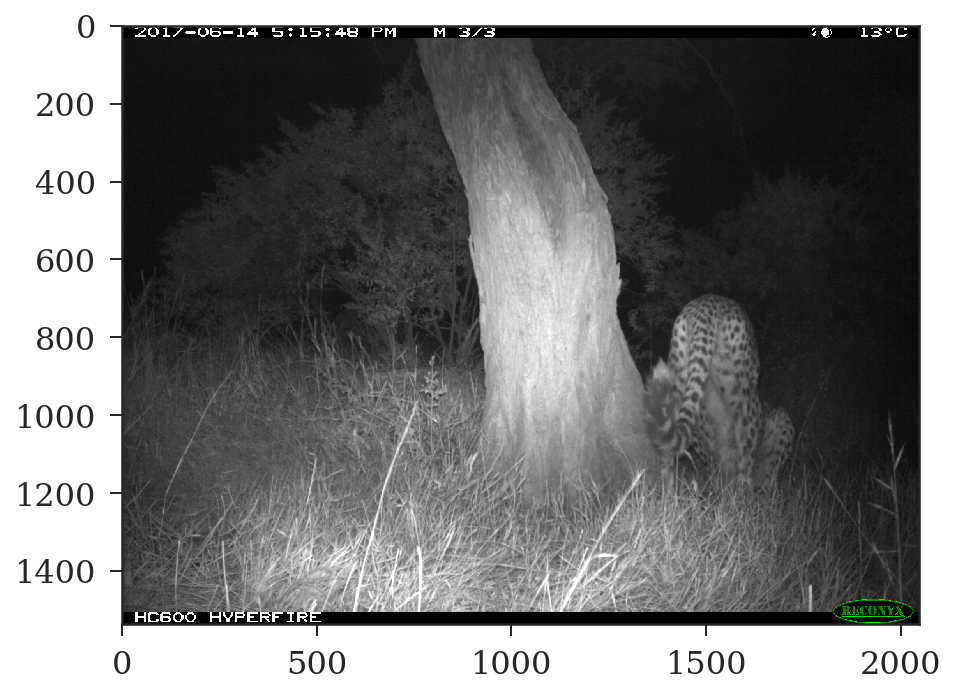

{'Ambient Temperature': 13,
 'Ambient Temperature Fahrenheit': 55,
 'Battery Voltage': 6770,
 'Brightness': 0,
 'Contrast': 160,
 'Date/Time Original': (48, 15, 17, 6, 14, 2017),
 'Event Number': (0, 385),
 'Firmware Version': 4,
 'Infrared Illuminator': 1,
 'Makernote Version': 61697,
 'Moon Phase': 5,
 'Motion Sensitivity': 100,
 'Saturation': 0,
 'Sequence': (3, 3),
 'Serial Number': b'H\x006\x000\x000\x00H\x00H\x000\x003\x002\x000\x004\x003\x000\x006\x00\x00\x00',
 'Sharpness': 32,
 'Trigger Mode': b'M\x00',
 'User Label': b'HC600 HYPERFIRE\x00\x00\x00\x00\x00\x00\x00'}

In [3]:
path = base_path + "/data/source_data/Cheetah/Cheetah_001884.jpg"
plt.imshow(plt.imread(path));plt.show()

meta = data_reader.read_im_exif(path)
meta

---
## Read the training/validation dataset

Here we just read the HDF5 file produced by the `split_data` notebook. It flags duplicates and images with conflicting data and expanded the events.

We can plot the distribution of events of the images in the training or validation set.

In [4]:
data = pandas.read_hdf(base_path + "/data/model_data/metadata.hdf5")

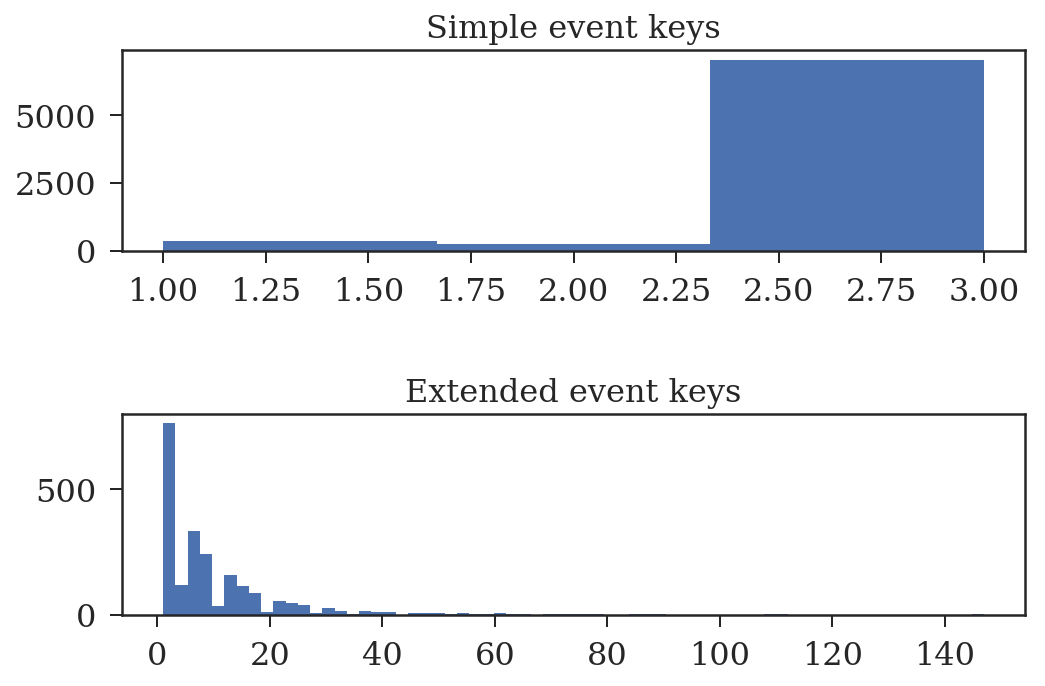

In [5]:
simple_lens = data[data.set != 'none'].groupby('event_key_simple')['event_key_simple'].count()
expanded_lens = data[data.set != 'none'].groupby('event_key')['event_key'].count()

plt.subplot(2,1,1)
plt.title("Simple event keys")
plt.hist(simple_lens, bins=len(np.unique(simple_lens)));

plt.subplot(2,1,2)
plt.title("Extended event keys")
plt.hist(expanded_lens, bins=len(np.unique(expanded_lens)));

plt.tight_layout()
plt.show();

---

## (Extended) events and train/val proportions

The simple events have been filtered so the labels are consistent. Do any extended events contain conflicting labels?

As we will see, some do, but even so - the conflicting simple events never make it into the training/validation dataset anyway.

In [6]:
# number of extended events (that share the 'event_key') with conflicting (i.e. more than 1) labels
conflict_labels_ext = data.groupby('event_key').filter(lambda x: x['label'].nunique() > 1)['event_key'].unique()
print(conflict_labels_ext[0])

H600HH03204240_2017_172_202


In [7]:
data[(data.event_key == conflict_labels_ext[0]) & (data.set == 'none')].head(20)

,ambient_temp,brightness,contrast,datetime,event1,event2,filename,hour,label,path,...,sequence_max,serial_no,set,sharpness,event_key_simple,sortkey,duplicates,timeoffset,event_key,set_path
15037,2,0,160,2017-06-21 01:19:35,0,212,Cheetah_010036.jpg,1,cheetah,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007975000000000,2,00:00:02,H600HH03204240_2017_172_202,NaN
1517,2,0,160,2017-06-21 01:19:35,0,212,Leopard_001477.jpg,1,leopard,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007975000000000,2,00:00:00,H600HH03204240_2017_172_202,NaN
8262,2,0,160,2017-06-21 01:19:36,0,212,Cheetah_010037.jpg,1,cheetah,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007976000000000,2,00:00:01,H600HH03204240_2017_172_202,NaN
466,2,0,160,2017-06-21 01:19:36,0,212,Leopard_001478.jpg,1,leopard,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007976000000000,2,00:00:00,H600HH03204240_2017_172_202,NaN
4966,2,0,160,2017-06-21 01:19:37,0,212,Cheetah_010038.jpg,1,cheetah,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007977000000000,2,00:00:01,H600HH03204240_2017_172_202,NaN
693,2,0,160,2017-06-21 01:19:37,0,212,Leopard_001479.jpg,1,leopard,/home/benjamin/Entwicklung/ComputerVision/Gepa...,...,3,H600HH03204240,none,32,H600HH03204240_2017_172_212,H600HH03204240_2017_172_2121498007977000000000,2,00:00:00,H600HH03204240_2017_172_202,NaN


Displaying 2 multi-label events (based on extended keys)


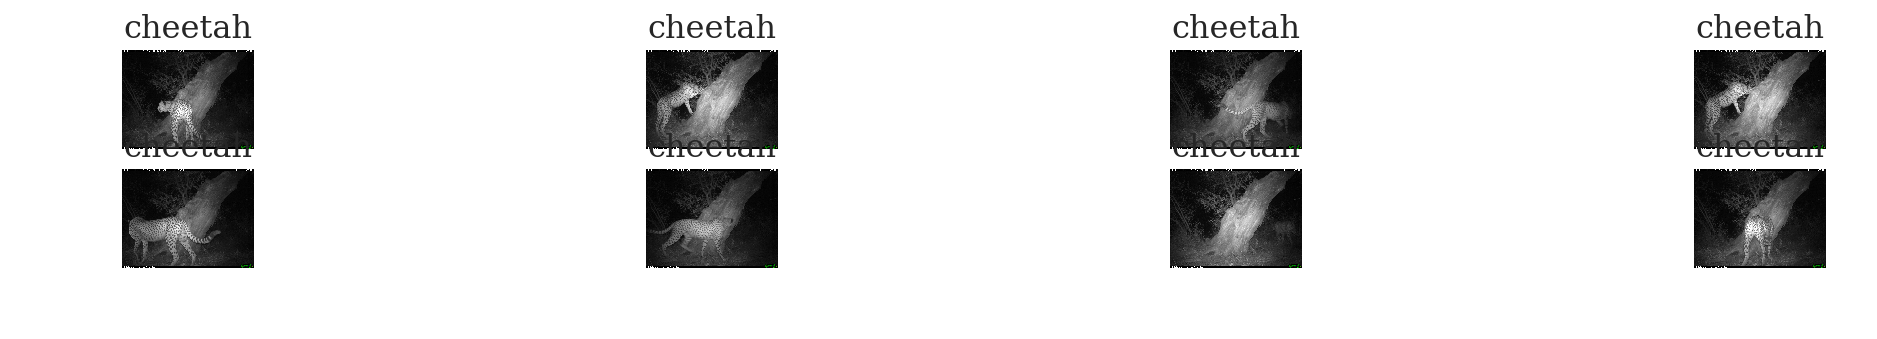

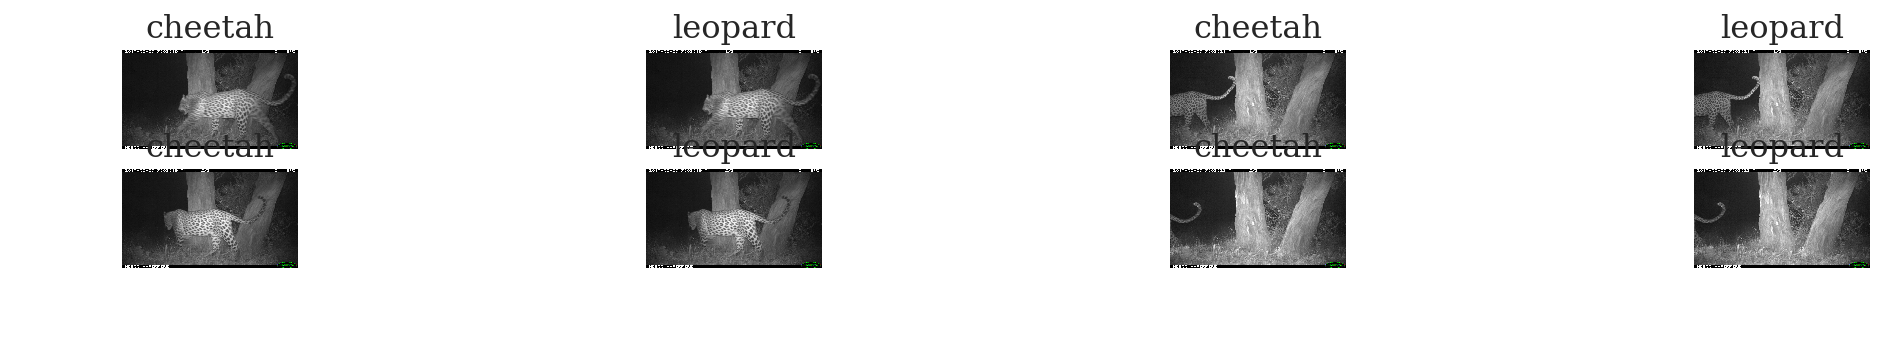

In [8]:
print ("Displaying {} multi-label events (based on extended keys)".format(len(conflict_labels_ext)))
for key in conflict_labels_ext:
    df = data[data.event_key == key].sort_values("sequence_idx")
    
    fig, axes = plt.subplots(2, 4, figsize=(18, 2))
    axes = [a for b in axes for a in b]
    for i, fname in enumerate(df.path.values):
        if i >= len(axes):
            break
        im = plt.imread(fname)
        axes[i].imshow(im)
        axes[i].axis("off")
        axes[i].set_aspect('equal')
        axes[i].set_title(df.label.values[i])
        plt.subplots_adjust(wspace=None, hspace=None)
    #fig.tight_layout()
    plt.show()

---

We can plot the proportions of the labels, sets and images not assigned to any set.

set      none  train   val
label                     
cheetah   500  13077  1475
leopard    18   1456   144
unknown    22   5342   543


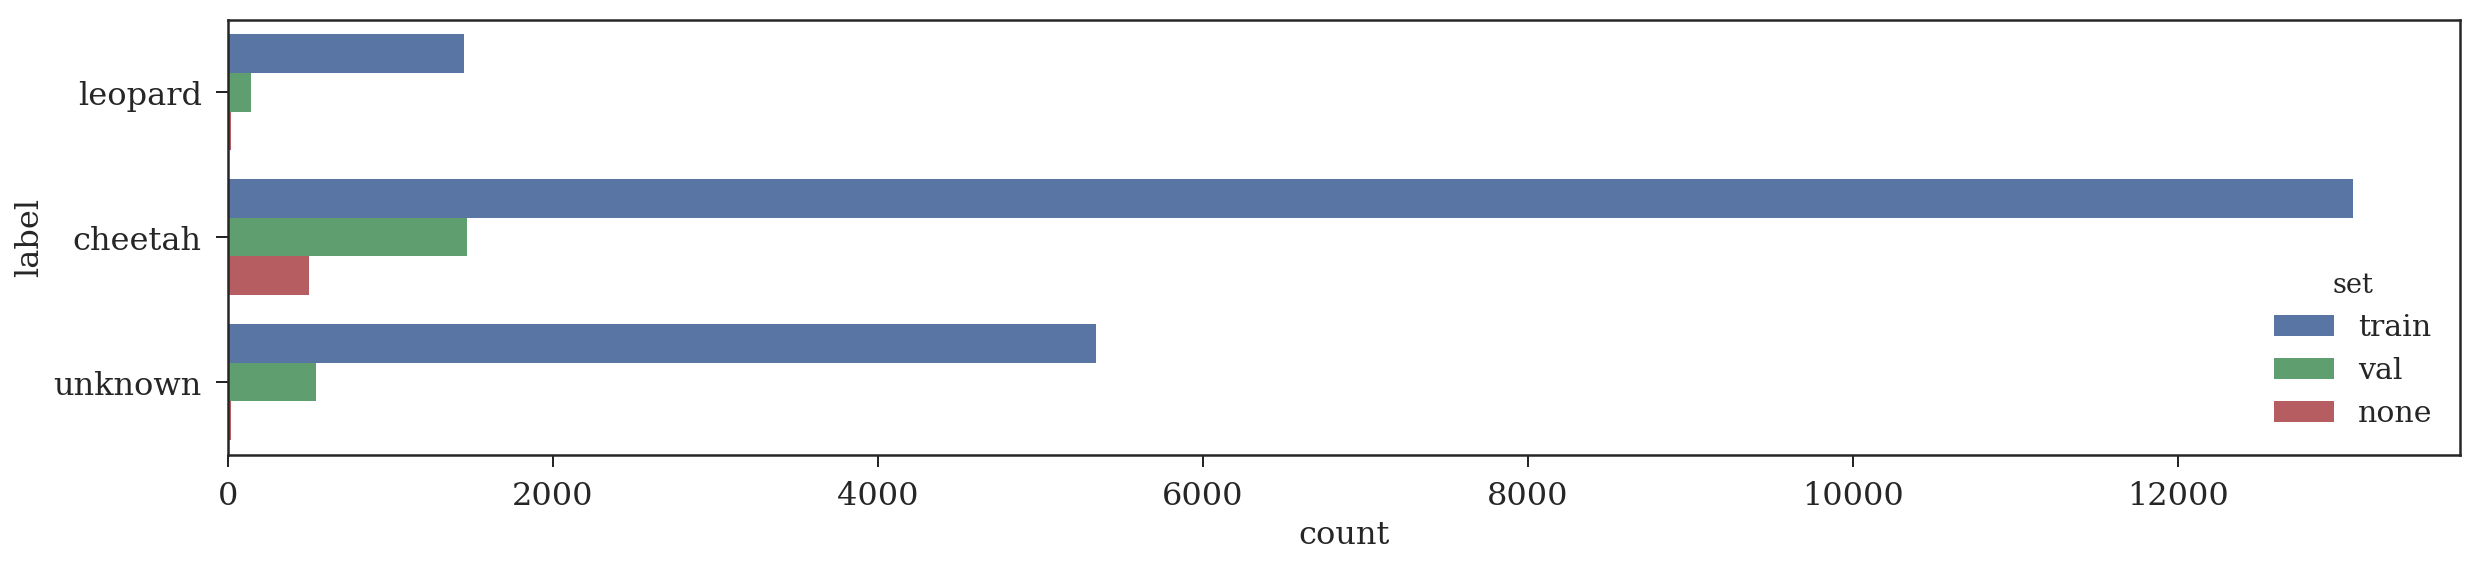

In [9]:
print(pandas.crosstab(data.label, data.set))

fig, ax = plt.subplots(1, 1, figsize=(20,4))
sns.countplot(data=data, y="label", hue="set", ax=ax)
plt.show()

---
# Simple baseline classifier

In the following sections, David trained a simple baseline classifier from timing/environmental clues like the temperature, time or brightness.

The experiments show that random guessing would likely yield an accuracy of 55.7%, the logistic classifier based on camera metadata reaches 65.5%.

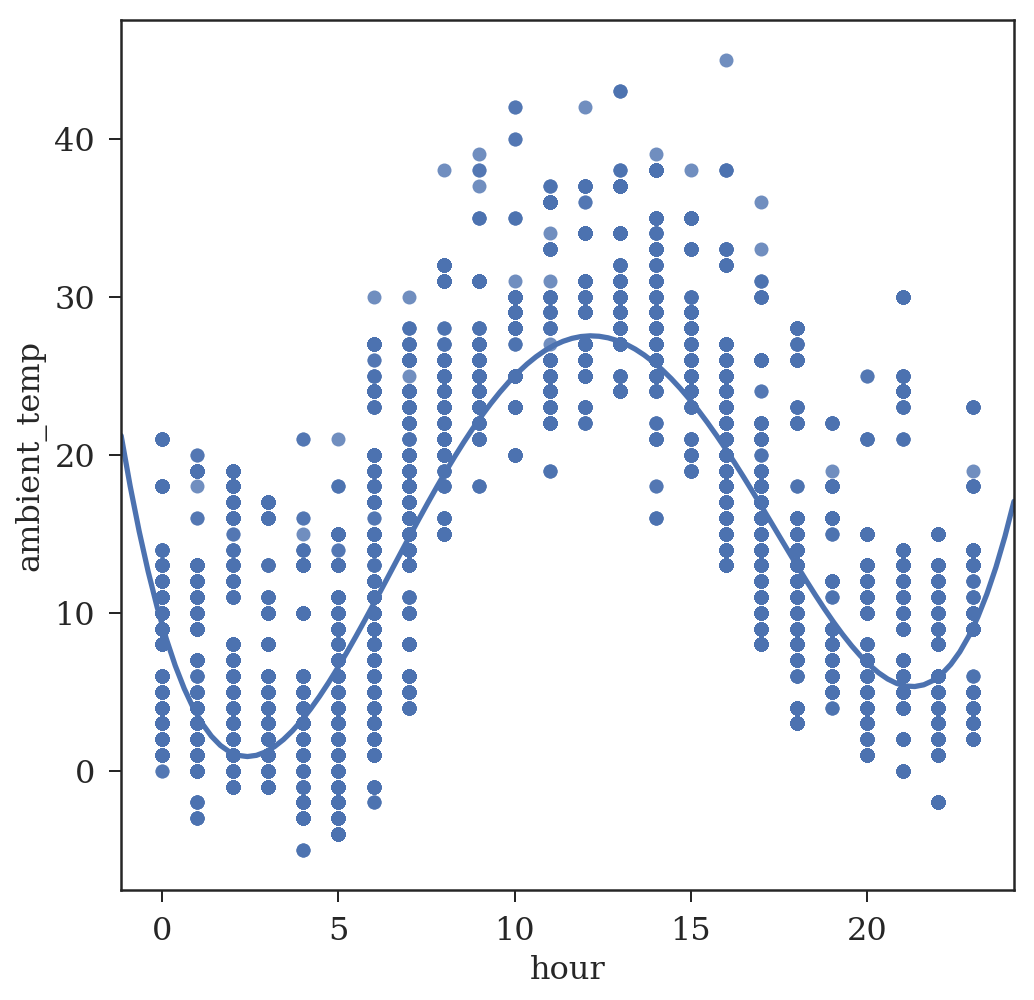

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.regplot(data=data, x="hour", y="ambient_temp", order=4, ax=ax)
plt.show()

In [11]:
data.columns

Index(['ambient_temp', 'brightness', 'contrast', 'datetime', 'event1',
       'event2', 'filename', 'hour', 'label', 'path', 'saturation',
       'sequence_idx', 'sequence_max', 'serial_no', 'set', 'sharpness',
       'event_key_simple', 'sortkey', 'duplicates', 'timeoffset', 'event_key',
       'set_path'],
      dtype='object')

In [12]:
X = data[["hour", "ambient_temp", "contrast", "brightness", "saturation", "sharpness"]].values
y = (data[["label"]].values == "cheetah").astype(np.int)[:,0]

model = sklearn.linear_model.LogisticRegressionCV()

cv = sklearn.model_selection.cross_val_score(model, X, y, cv=5)
print ("{}: score {:3.1%}".format(str(model), cv.mean()))

model = sklearn.dummy.DummyClassifier()
cv = sklearn.model_selection.cross_val_score(model, X, y, cv=5)
print ("{}: score {:3.1%}".format(str(model), cv.mean()))

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0): score 65.5%
DummyClassifier(constant=None, random_state=None, strategy='stratified'): score 55.9%


In [13]:
model = sklearn.linear_model.LogisticRegressionCV()
model.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

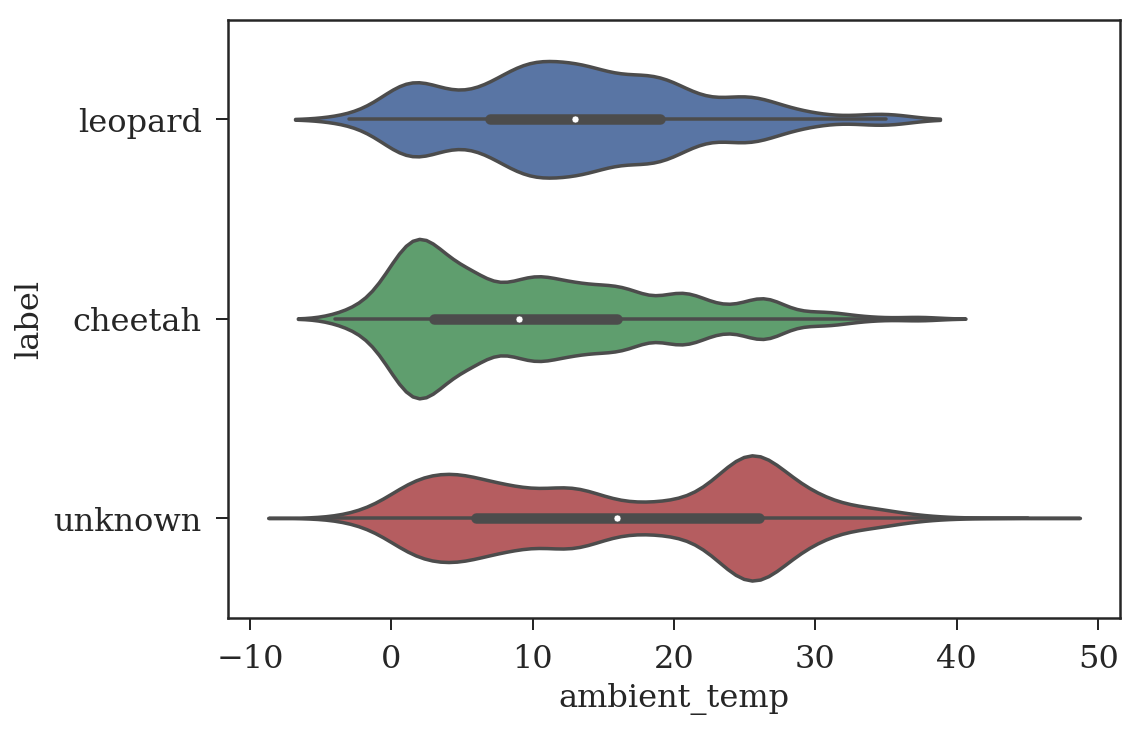

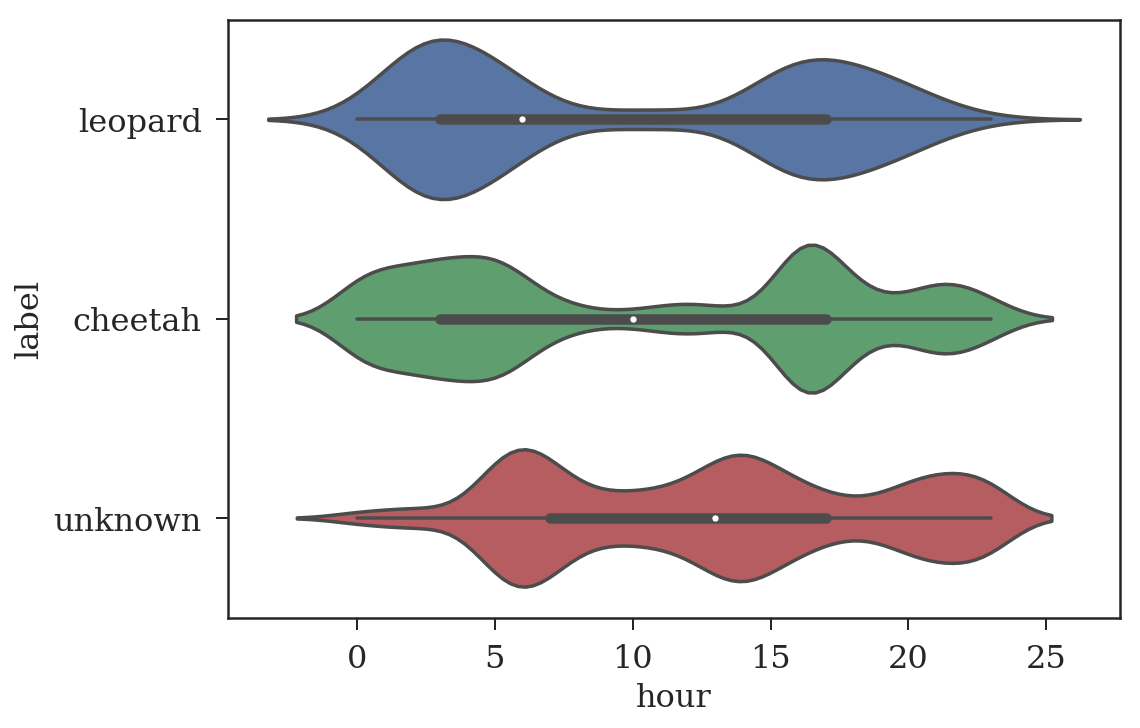

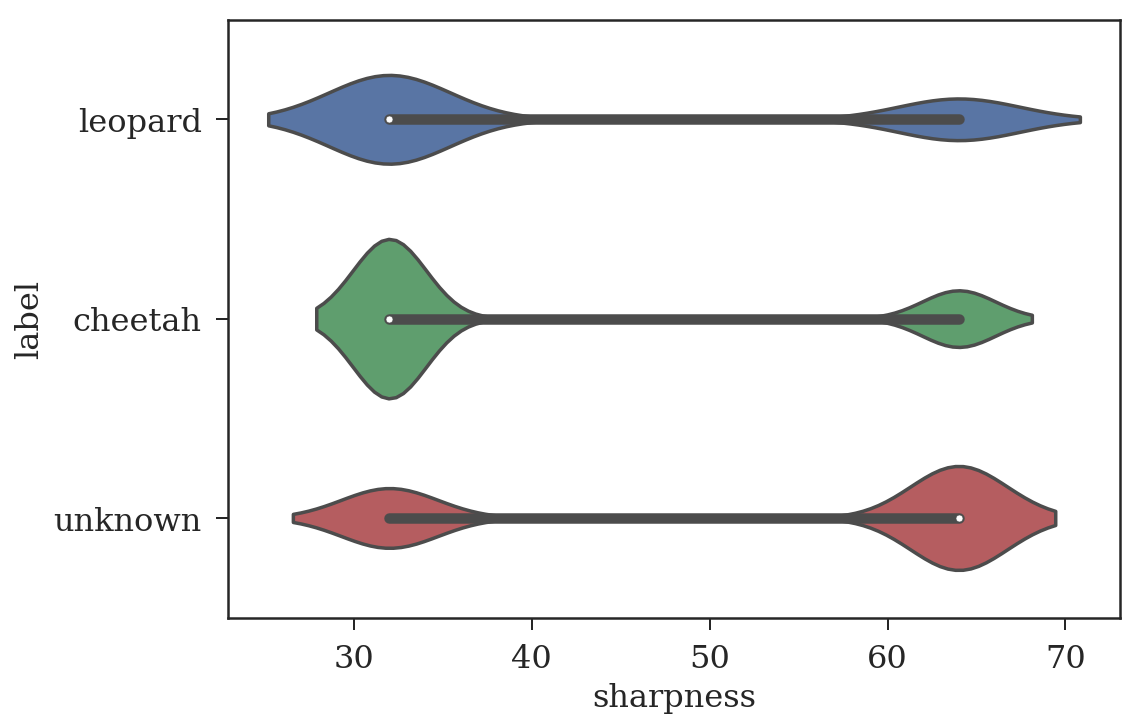

In [14]:
sns.violinplot(data=data, y="label", x="ambient_temp");plt.show()
sns.violinplot(data=data, y="label", x="hour");plt.show()
sns.violinplot(data=data, y="label", x="sharpness");plt.show()